In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score, StratifiedShuffleSplit

from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


import hyperopt

import woe_func
import PSI_value_func

In [2]:
df_train = pd.read_csv(r'C:\Users\User\Desktop\Коллекция для Git\Tasks\train.csv')
df_test = pd.read_csv(r'C:\Users\User\Desktop\Коллекция для Git\Tasks\test.csv')

## Описание колонок

'PassengerId':'Номер_пассажира',                                                                                    
'Survived': 'Выжил',                                              
'Pclass': 'класс_билета',                                                 
'Sex': 'Пол',                                                           
'Age': 'Возраст',                                                                                         
'SibSp': 'Братьев_сестер',                                           
'Parch': 'Родителей_детей',                                               
'Fare': 'Тариф',                                                   
'Cabin': 'Номер_каюты',                                                   
'Embarked': 'Порт_погрузки',                                                      
'Ticket': 'Номер_билета',                                                    
'Name': 'Имя'

In [3]:
print(f'В тренировочном наборе |   строк: {df_train.shape[0]}; столбцов: {df_train.shape[1]}')
print(f'В тестовом наборе      |   строк: {df_test.shape[0]}; столбцов: {df_test.shape[1]}')

В тренировочном наборе |   строк: 891; столбцов: 12
В тестовом наборе      |   строк: 418; столбцов: 11


In [4]:
col = ['Pclass', 'Age', 'Fare', 'SibSp', 'Parch', 'Sex', 'Cabin', 'Ticket', 'Embarked', 'Name']

train = df_train.drop(['Survived', 'PassengerId'], axis=1)[col].copy()
target = df_train.Survived.copy()

test = df_test.drop('PassengerId', axis=1)[col].copy()

### 1. Первичный просмотр, пустоты, доп колонки

In [5]:
ss = StandardScaler()          # ss.fit_transform(tr_ts['Age'])
le = LabelEncoder()            # le.fit_transform(tr_ts['Sex'])
oh = OneHotEncoder()           # pd.DataFrame(oh.fit_transform(tr_ts[['Sex']]).toarray(), columns=sorted(list(tr_ts['Sex'].unique())))      # этот луччше

In [6]:
# преобразуем колонки в обоих сетах сразу - объединяем

tr_ts = pd.concat([train, test])

In [7]:
tr_ts.head()

,Pclass,Age,Fare,SibSp,Parch,Sex,Cabin,Ticket,Embarked,Name
0,3,22.0,7.2500,1,0,male,NaN,A/5 21171,S,"Braund, Mr. Owen Harris"
1,1,38.0,71.2833,1,0,female,C85,PC 17599,C,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,3,26.0,7.9250,0,0,female,NaN,STON/O2. 3101282,S,"Heikkinen, Miss. Laina"
3,1,35.0,53.1000,1,0,female,C123,113803,S,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,3,35.0,8.0500,0,0,male,NaN,373450,S,"Allen, Mr. William Henry"


In [8]:
#### ЗАПОЛНИМ ПУСТОТЫ для RF_clf


mean_age_by_classes = tr_ts.loc[tr_ts['Age'].notna()].groupby('Pclass', as_index=False).agg({'Age':'mean'})
mean_fare_by_classes = tr_ts.loc[tr_ts['Fare'].notna()].groupby('Pclass', as_index=False).agg({'Fare':'mean'})
mode_embarked_by_classes = tr_ts.loc[tr_ts['Embarked'].notna()].groupby(['Pclass', 'Embarked'], as_index=False).agg({'Age':'count'})


tr_ts.loc[(tr_ts['Age'].isnull()) & (tr_ts['Pclass'] == 1), 'Age'] = mean_age_by_classes.loc[mean_age_by_classes['Pclass'] == 1, 'Age'].values[0]
tr_ts.loc[(tr_ts['Age'].isnull()) & (tr_ts['Pclass'] == 2), 'Age'] = mean_age_by_classes.loc[mean_age_by_classes['Pclass'] == 2, 'Age'].values[0]
tr_ts.loc[(tr_ts['Age'].isnull()) & (tr_ts['Pclass'] == 3), 'Age'] = mean_age_by_classes.loc[mean_age_by_classes['Pclass'] == 3, 'Age'].values[0]


tr_ts.Fare.fillna(tr_ts[(tr_ts.Pclass == 3) & (tr_ts.Embarked == "S") & (tr_ts.Sex == "male")].Fare.mean(), inplace=True)     # заменяем сразу
 

tr_ts.loc[(tr_ts['Embarked'].isnull()) & (tr_ts['Pclass'] == 1), 'Embarked'] = 'C'   # там ближайший из Fare == 80 долларам ближе к С

In [9]:
tr_ts.isnull().sum()

Pclass         0
Age            0
Fare           0
SibSp          0
Parch          0
Sex            0
Cabin       1014
Ticket         0
Embarked       0
Name           0
dtype: int64

In [10]:
# Доп колонки 

tr_ts['Title'] = tr_ts['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
tr_ts['FamilySize'] = tr_ts['SibSp'] + tr_ts['Parch'] + 1
tr_ts['LastName'] = tr_ts['Name'].apply(lambda x: x.split(',')[0])
tr_ts['FamilyGroup'] = tr_ts['LastName'] + "_" + tr_ts['FamilySize'].astype(str)

family_cabin_mapping = tr_ts.dropna(subset=['Cabin']).groupby('FamilyGroup')['Cabin'].agg(lambda x:x.value_counts().index[0])
#tr_ts['Cabin'] = tr_ts.apply(lambda x: family_cabin_mapping.get(x['FamilyGroup'], x['Cabin']), axis=1)

# добавим просто две фичи посмотреть по показателям

#tr_ts['Age_log'] = np.where((tr_ts['Age'].isnull()) | (tr_ts['Age'] == 0), np.nan, np.log(tr_ts['Age']))
#tr_ts['Fare_log'] = np.where( (tr_ts['Fare'].isnull()) | (tr_ts['Fare'] == 0), 0, np.log(tr_ts['Fare']))

In [11]:
tr_ts['Cabin'] = tr_ts['Cabin'].fillna('N')

tr_ts.Cabin = [i[0] for i in tr_ts.Cabin]

In [12]:
# tr_ts.groupby("Cabin")['Fare'].mean().sort_values()

In [13]:
def cabin_estimator(i):
    """Grouping cabin feature by the first letter"""
    a = 0
    if i<16:
        a = "G"
    elif i>=16 and i<27:
        a = "F"
    elif i>=27 and i<38:
        a = "T"
    elif i>=38 and i<47:
        a = "A"
    elif i>= 47 and i<53:
        a = "E"
    elif i>= 53 and i<54:
        a = "D"
    elif i>=54 and i<116:
        a = 'C'
    else:
        a = "B"
    return a

In [14]:
#tr_ts.loc[tr_ts.Cabin == 'N', 'Cabin'] = tr_ts.loc[tr_ts.Cabin == 'N', 'Fare'].apply(lambda x: cabin_estimator(x))

In [15]:
tr_ts.isnull().sum()

Pclass         0
Age            0
Fare           0
SibSp          0
Parch          0
Sex            0
Cabin          0
Ticket         0
Embarked       0
Name           0
Title          0
FamilySize     0
LastName       0
FamilyGroup    0
dtype: int64

In [16]:
tr_ts.head(3)

,Pclass,Age,Fare,SibSp,Parch,Sex,Cabin,Ticket,Embarked,Name,Title,FamilySize,LastName,FamilyGroup
0,3,22.0,7.2500,1,0,male,N,A/5 21171,S,"Braund, Mr. Owen Harris",Mr,2,Braund,Braund_2
1,1,38.0,71.2833,1,0,female,C,PC 17599,C,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs,2,Cumings,Cumings_2
2,3,26.0,7.9250,0,0,female,N,STON/O2. 3101282,S,"Heikkinen, Miss. Laina",Miss,1,Heikkinen,Heikkinen_1


In [17]:
tr_ts['name_length'] = [len(i) for i in tr_ts.Name]

def name_length_group(size):
    a = ''
    if (size <=20):
        a = 'short'
    elif (size <=35):
        a = 'medium'
    elif (size <=45):
        a = 'good'
    else:
        a = 'long'
    return a

#tr_ts['nLength_group'] = tr_ts['name_length'].map(name_length_group)

In [18]:
tr_ts['Title'] = np.select([tr_ts['Title'].isin(['Ms', 'Mlle']), 
                            tr_ts['Title'].isin(['Mme']), 
                            tr_ts['Title'].isin(['Dr', 'Col', 'Rev', 'Major', 'Don', 'Jonkheer', 'Sir', 'Lady', 'Capt', 'Countess', 'Dona'])],
                           
                           ['Miss', 'Mrs', 'rare'], 
                           
                           tr_ts['Title'])

In [19]:
def family_group(size):
    """
    This funciton groups(loner, small, large) family based on family size
    """
    
    a = ''
    if (size <= 1):
        a = 'loner'
    elif (size <= 4):
        a = 'small'
    else:
        a = 'large'
    return a

#tr_ts['FamilyGroup_ver2'] = tr_ts['FamilySize'].map(family_group)

In [20]:
#tr_ts['is_alone'] = [1 if i < 2 else 0 for i in tr_ts['FamilySize']]

In [21]:
tr_ts['calculated_fare'] = tr_ts.Fare / tr_ts.FamilySize

In [22]:
def fare_group(fare):
    """
    This function creates a fare group based on the fare provided
    """
    
    a= ''
    if fare <= 4:
        a = 'Very_low'
    elif fare <= 10:
        a = 'low'
    elif fare <= 20:
        a = 'mid'
    elif fare <= 45:
        a = 'high'
    else:
        a = "very_high"
    return a

tr_ts['fare_group'] = tr_ts['calculated_fare'].map(fare_group)

In [23]:
def age_group_fun(age):
    """
    This function creates a bin for age
    """
    a = ''
    if age <= 1:
        a = 'infant'
    elif age <= 4: 
        a = 'toddler'
    elif age <= 13:
        a = 'child'
    elif age <= 18:
        a = 'teenager'
    elif age <= 35:
        a = 'Young_Adult'
    elif age <= 45:
        a = 'adult'
    elif age <= 55:
        a = 'middle_aged'
    elif age <= 65:
        a = 'senior_citizen'
    else:
        a = 'old'
    return a

#tr_ts['age_group'] = tr_ts['Age'].map(age_group_fun)

In [24]:
tr_ts['Ticket_group'] = np.select([tr_ts['Ticket'].str[0] == 'A', 
                                   tr_ts['Ticket'].str[0] == 'C', 
                                   tr_ts['Ticket'].str[0] == 'F', 
                                   tr_ts['Ticket'].str[0] == 'P', 
                                   tr_ts['Ticket'].str[0] == 'S', 
                                   tr_ts['Ticket'].str[0] == 'W'], 
                                     
                                  ['A', 'C', 'F', 'P', 'S', 'W'], 
                                     
                                  'Number')

In [25]:
tc_for_merge = tr_ts.groupby('Ticket').agg({'Age': 'count'}).reset_index().rename(columns={'Age': 'Ticket_count'})

tr_ts = tr_ts.merge(tc_for_merge, how='left', on='Ticket')

In [26]:
tr_ts['Ticket_count'] = np.select([tr_ts['Ticket_count'] == 1, tr_ts['Ticket_count'] <= 4, tr_ts['Ticket_count'] > 4], 
                                  
                                  ['one', 'few', 'lot'], 
                                  
                                  'error') 

In [27]:
# все что использовано - дропаем

tr_ts = tr_ts.drop(['Name', 'name_length', 'LastName', 'SibSp', 'Parch', 'Ticket', 
                    'FamilyGroup', 'calculated_fare', 'Ticket_group', 'fare_group' ], axis=1)

In [28]:
tr_ts.head()

,Pclass,Age,Fare,Sex,Cabin,Embarked,Title,FamilySize,Ticket_count
0,3,22.0,7.2500,male,N,S,Mr,2,one
1,1,38.0,71.2833,female,C,C,Mrs,2,few
2,3,26.0,7.9250,female,N,S,Miss,1,one
3,1,35.0,53.1000,female,C,S,Mrs,2,few
4,3,35.0,8.0500,male,N,S,Mr,1,one


In [29]:
tr_ts = pd.get_dummies(tr_ts, columns=['Pclass', 'Sex', 'Embarked', 
                                       'Title', 'FamilySize', 'Ticket_count', 'Cabin'])  

# или

#for col in ['Sex', 'Embarked', 'Cabin', 'Title', 'Ticket_count']:
#    tr_ts[col] = le.fit_transform(tr_ts[col])

In [30]:
tr_ts.head()

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,Ticket_count_one,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T
0,22.0,7.2500,0,0,1,0,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,38.0,71.2833,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,26.0,7.9250,0,0,1,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
3,35.0,53.1000,1,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,35.0,8.0500,0,0,1,0,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0


In [31]:
tr_ts.loc[:] = ss.fit_transform(tr_ts)

In [32]:
tr_ts.head(3)

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,Ticket_count_one,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T
0,-0.559957,-0.503268,-0.572351,-0.518084,0.919925,-0.743497,0.743497,-0.512148,-0.32204,0.657394,...,0.914278,-0.130744,-0.228584,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,0.539377,-0.02765
1,0.659292,0.734758,1.747178,-0.518084,-1.087045,1.344995,-1.344995,1.952562,-0.32204,-1.521159,...,-1.093759,-0.130744,-0.228584,3.595210,-0.190843,-0.179818,-0.127688,-0.061922,-1.853992,-0.02765
2,-0.255145,-0.490218,-0.572351,-0.518084,0.919925,1.344995,-1.344995,-0.512148,-0.32204,0.657394,...,0.914278,-0.130744,-0.228584,-0.278148,-0.190843,-0.179818,-0.127688,-0.061922,0.539377,-0.02765


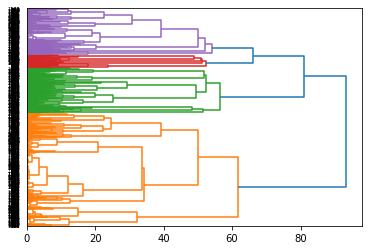

In [33]:
# Иерархический кластерный - рисуем чтобы увидеть количество возможных кластеров

link = linkage(tr_ts, 'ward', 'euclidean')
dn = dendrogram(link, orientation='right')

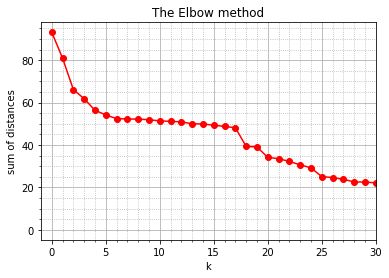

In [34]:
# по сумме расстояний смотрим, когда она меняется не сильно - количество кластеров уже увеличивать не следует (в нашем случае 3 (3-я точка слева)) 

dist = list(link[:,2])[::-1]
plt.plot(range(0, len(link)), dist, marker='o', color='r')
plt.xlabel('k')
plt.ylabel('sum of distances')
plt.title('The Elbow method')
plt.xlim([-1, 30])

plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

In [35]:
# делаем кластер фичей

tr_ts['cluster_ierarchy'] = fcluster(link, 70, criterion='distance')

In [36]:
tr_ts.cluster_ierarchy.value_counts()

1    683
3    355
2    271
Name: cluster_ierarchy, dtype: int64

In [37]:
tr_ts.loc[:, 'cluster_ierarchy'] = ss.fit_transform( np.array(tr_ts.loc[:, 'cluster_ierarchy']).reshape(-1,1) )

In [38]:
tr_ts.cluster_ierarchy.value_counts()

-0.877027    683
 1.463500    355
 0.293236    271
Name: cluster_ierarchy, dtype: int64

In [39]:
tr_ts.isnull().sum().sum()

0

In [40]:
tr_ts.shape

(1309, 37)

In [41]:
train_ = tr_ts.iloc[:len(df_train)].copy()

# target

test_ = tr_ts.iloc[len(df_train):].copy()

#### Выбросы 

In [42]:
# иногда это работает, но это сложно объяснить вразумительно 

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca = pca.fit(train_)

In [43]:
# доля объясненной дисперсии

pca.explained_variance_ratio_

array([0.15263347, 0.09708968])

In [44]:
train_pca = pd.DataFrame(pca.transform(train_)).rename(columns={0: 'x', 1: 'y'})

train_pca = pd.concat([train_pca, df_train['Survived']], axis=1)

test_pca = pd.DataFrame(pca.transform(test_)).rename(columns={0: 'x', 1: 'y'})

In [45]:
train_pca

,x,y,Survived
0,-1.748340,-0.157202,0
1,4.813573,2.541149,1
2,0.337105,-2.277461,1
3,4.311545,1.834248,1
4,-2.763942,0.064587,0
...,...,...,...
886,-1.205724,0.551194,0
887,2.043775,0.880046,1
888,2.605183,-2.642063,0
889,-0.094315,3.202889,1


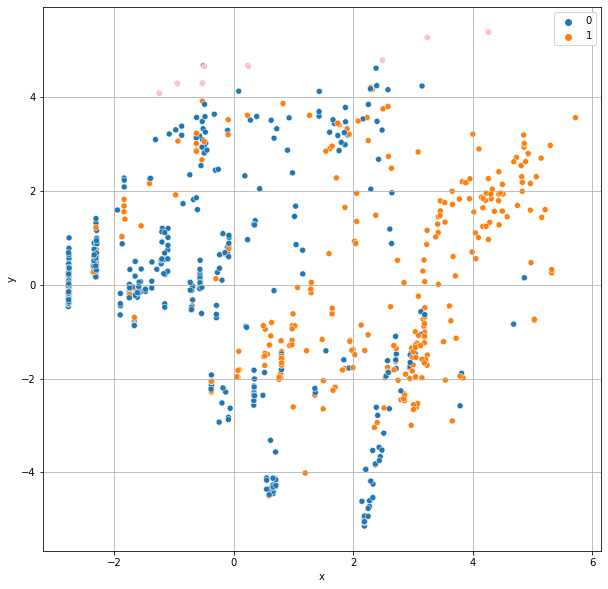

In [46]:
# те которые я до этого выкинул = condition_point = train_pca.index.isin([96, 174, 339, 599, 630, 647, 679, 737]) 

plt.figure(figsize=(10, 10))

sns.scatterplot(data=train_pca, x='x', y='y', hue='Survived')                       # трейн - на нем обучим
#sns.scatterplot(data=test_pca, x=test_pca['x'], y=test_pca['y'], color='black')     # тест  - его предсказываем

#sns.lineplot(x=x, y=y, color='red')
#sns.lineplot(data=train_pca, x='x', y='border_1', color='red')
#sns.lineplot(data=train_pca, x='x', y='border_2', color='red')

# ищем что не должно зайти в трейн
# 0 - умер
# 1 - выжил

#condition_1 =  (train_pca['y'] < -4.3)
#condition_1 = (train_pca['x'] > 0) & (train_pca['y'] < -4.3) 
#condition_2 = (train_pca['x'] > 4) & (train_pca['y'] > 0) & (train_pca['Survived'] == 0)
#condition_3 = (train_pca['y'] > 3.8) & (train_pca['Survived'] == 1)


condition_point = train_pca.index.isin([96, 174, 339, 599, 630, 647, 679, 737]) 

#condition_border_1 = (train_pca['y'] < train_pca['border_1']) & (train_pca['Survived'] == 1)
#condition_border_2 = (train_pca['y'] > train_pca['border_2']) & (train_pca['Survived'] == 0)

sns.scatterplot(data = train_pca, x=train_pca.loc[(condition_point) , 'x'], 
                                  y=train_pca.loc[(condition_point) , 'y'], color='pink')

plt.grid()

In [47]:
ejections_train_lst = [96, 174, 339, 599, 630, 647, 679, 737]; ejections_train_lst

[96, 174, 339, 599, 630, 647, 679, 737]

#### ------------------

In [48]:
# выбросы
train_ = train_.loc[~train_.index.isin(ejections_train_lst)]

target = target[~target.index.isin(ejections_train_lst)]

### 2. Предобработка предикторов

In [49]:
# Делаем все без заполнения пустот

# 1. создаем df для аналитической информации

df_analysis = pd.DataFrame(columns=['feature'])

In [50]:
df_analysis

,feature


In [51]:
# для расчета woe склеим 

df = pd.concat([train_, target], axis=1)

goods = df.shape[0] - df['Survived'].sum()
bads = df['Survived'].sum()

In [52]:
to_remove = []

intervals = dict()                # словарь вида   {'фича': [пороговые_зн_интервалов]}

col_without_woe = []

woe_values_in_intervals = dict()                    # словарь вида {'фича': pd.Series, ...} с индексами порогами интервалов и значениями woe
woe_values_in_intervals_full_info = dict()          # словарь вида {'фича': {'WOES': pd.Series, 'BINS': список границ интервалов}}

# вычисляем пороги
for num_column in df.drop('Survived', axis=1).columns:   
    intervals[num_column] = woe_func.get_monotonic_bins(num_column, df, 'Survived', goods=goods, bads=bads)          # вычисление пороговых значений интервалов

# формируем словарь со значениями и порогами        
for num_column in df.drop('Survived', axis=1).columns:
    
    if intervals[num_column] is None:
        col_without_woe.append(num_column)                  # на всякий посчитаем колонки без разделения
        continue                                            # для None оставшееся в итерации выполнено не будет 
    
    # woe_values_in_intervals[num_column] = woe_func.get_woe_bins(num_column, df, 'Survived', intervals, goods=goods, bads=bads)
    
    woe_values_in_intervals_full_info[num_column] = {'WOES': woe_func.get_woe_bins(num_column, df, 'Survived', intervals, goods=goods, bads=bads), 
                                                     'BINS': intervals[num_column]} 

# формируем таблицу df со значениями woe
woe_series = []
for num_column in [col for col in df.drop('Survived', axis=1).columns if col not in col_without_woe]:
    woe_series.append(woe_func.transform2woe(num_column, df, woe_values_in_intervals_full_info))

woe_df = pd.DataFrame(woe_series).T   
woe_df['target'] = df['Survived']

#### 1. Цикл обработки

In [53]:
# все колонки уже должны быть количественными 

fill_percent_list = []
mode_frequency_list = []
woe_existence_list = []
gini_list = []
gini_woe_list =[]
uniq_val = []
psi_values = []

for num_column in train_.columns:
    # 1. пустоты
    fill_percent = np.round(train_[num_column].notna().sum() / len(train_), 3)
    fill_percent_list.append(fill_percent)
    
    # 2. частота моды
    mode_frequency = round(train_.loc[train_[num_column] == train_[num_column].mode()[0]].shape[0] / train_[num_column].notna().sum(), 3)
    mode_frequency_list.append(mode_frequency)
      
    # 3. возможность разделения деревом (woe)
   
    if num_column in col_without_woe:
        woe_existence_list.append(0)
    else:
        woe_existence_list.append(1)
    
    # 4. индивидуальный джини  (тут берем из df, т.к. нужен таргет)
    try:
        gini_series = df[df[num_column].notna()]         
        gini = np.round(abs(roc_auc_score(gini_series['Survived'], gini_series[num_column]))*2 - 1, 3)
        gini_list.append(gini)
    except:
        gini_list.append(np.nan)
    
    # 5. woe джини
    try:
        gini_woe_series = woe_df[woe_df[num_column].notna()]
        gini_woe = np.round(abs(roc_auc_score(gini_woe_series['target'], gini_woe_series[num_column]))*2 - 1, 3)
        gini_woe_list.append(gini_woe)
    except:
        gini_woe_list.append(np.nan)
    
    # 6. nunique()
    
    uniq_val_col = train_[num_column].nunique(dropna=False)
    uniq_val.append(uniq_val_col)
    
    # 7. psi_value
    
    if uniq_val_col > 10 and num_column in test_.columns:
        psi = PSI_value_func.calculate_psi(train_[num_column], test_[num_column]) 
    else:
        psi = np.nan
    
    psi_values.append(psi)
    
df_analysis['feature'] = train_.columns                # фича
df_analysis['filling_percent'] = fill_percent_list     # доля заполненных зн-ий
df_analysis['mode_frequency'] = mode_frequency_list    # доля моды
df_analysis['woe_flag'] = woe_existence_list           # возможность построить бинарное дерево
df_analysis['ind_gini'] = gini_list                    # gini по фиче
df_analysis['woe_gini'] = gini_woe_list                # gini по фиче из woe_df 
df_analysis['uniq_val_with_Nan'] = uniq_val            # количество уникальных значений в колонке (считая Нан)
df_analysis['psi_value_tr_ts'] = psi_values

In [54]:
df_analysis.tail(30)

,feature,filling_percent,mode_frequency,woe_flag,ind_gini,woe_gini,uniq_val_with_Nan,psi_value_tr_ts
7,Embarked_C,1.0,0.814,1,0.136,-0.136,2,NaN
8,Embarked_Q,1.0,0.913,1,0.003,-0.003,2,NaN
9,Embarked_S,1.0,0.727,1,-0.139,-0.139,2,NaN
10,Title_Master,1.0,0.955,0,0.037,NaN,2,NaN
11,Title_Miss,1.0,0.790,1,0.285,-0.285,2,NaN
12,Title_Mr,1.0,0.579,1,-0.562,-0.562,2,NaN
13,Title_Mrs,1.0,0.857,1,0.249,-0.249,2,NaN
14,Title_rare,1.0,0.976,0,-0.010,NaN,2,NaN
15,FamilySize_1,1.0,0.601,1,-0.205,-0.205,2,NaN
16,FamilySize_2,1.0,0.820,1,0.126,-0.126,2,NaN


In [55]:
columns_well = df_analysis.loc[(df_analysis.filling_percent > 0.05) & 
                               (df_analysis.mode_frequency < 0.95) & 
                               (df_analysis.woe_flag == 1) & 
                               ((abs(df_analysis.woe_gini) > 0.2) & (abs(df_analysis.ind_gini) > 0.2)) & 
                               ((df_analysis.psi_value_tr_ts < 0.1) | (df_analysis.psi_value_tr_ts.isnull())) & 
                               (~df_analysis.feature.isin(['new_col_1', 'new_col_2']))] \
                          .feature \
                          .to_list()

In [56]:
#train_.corr()

In [57]:
#columns_well = [col for col in df_analysis.feature ]

In [58]:
columns_well

['Fare',
 'Pclass_1',
 'Pclass_3',
 'Sex_female',
 'Sex_male',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'FamilySize_1',
 'Ticket_count_few',
 'Ticket_count_one',
 'Cabin_N',
 'cluster_ierarchy']

#### 2. Обучение

In [59]:
train_end = train_[columns_well].copy()
test_end = test_[columns_well].copy()

In [60]:
X = train_end
y = target

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)

In [62]:
X_train.columns

Index(['Fare', 'Pclass_1', 'Pclass_3', 'Sex_female', 'Sex_male', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'FamilySize_1', 'Ticket_count_few',
       'Ticket_count_one', 'Cabin_N', 'cluster_ierarchy'],
      dtype='object')

In [63]:
X_train.head(3)

,Fare,Pclass_1,Pclass_3,Sex_female,Sex_male,Title_Miss,Title_Mr,Title_Mrs,FamilySize_1,Ticket_count_few,Ticket_count_one,Cabin_N,cluster_ierarchy
461,-0.487801,-0.572351,0.919925,-0.743497,0.743497,-0.502625,0.853929,-0.422159,0.810532,-0.754682,0.914278,0.539377,-0.877027
505,1.462042,1.747178,-1.087045,-0.743497,0.743497,-0.502625,0.853929,-0.422159,-1.233758,1.325062,-1.093759,-1.853992,0.293236
667,-0.493118,-0.572351,0.919925,-0.743497,0.743497,-0.502625,0.853929,-0.422159,0.810532,-0.754682,0.914278,0.539377,-0.877027


### RF

In [64]:
model_rf = RandomForestClassifier(random_state=17)

params = {'n_estimators': range(50, 140), 
          'max_depth': range(3, 16), 
          'max_features': range(2, 9), 
          'min_samples_split': range(2, 10), 
          'min_samples_leaf': range(2, 50)}

In [65]:
skf_1 = StratifiedKFold(n_splits = 4, shuffle=True, random_state=0)

r_search_CV = RandomizedSearchCV(model_rf, param_distributions=params, cv=skf_1)
r_search_CV.fit(X_train, y_train)
best_model = r_search_CV.best_estimator_
best_val_score = cross_val_score(best_model, X_train, y_train, cv = skf_1, scoring = 'roc_auc').mean()

print(f'Лучшие параметры - {r_search_CV.best_params_}')
print(f'Score на трейне - {best_model.score(X_train, y_train)}')
print(f'Score на валидации - {best_val_score}')

Лучшие параметры - {'n_estimators': 125, 'min_samples_split': 4, 'min_samples_leaf': 13, 'max_features': 7, 'max_depth': 15}
Score на трейне - 0.843042071197411
Score на валидации - 0.883041857373504


In [66]:
params_best = r_search_CV.best_params_

model_rf = RandomForestClassifier(**params_best, random_state=17).fit(X_train, y_train)

In [67]:
y_predict = model_rf.predict(X_test)

<AxesSubplot:>

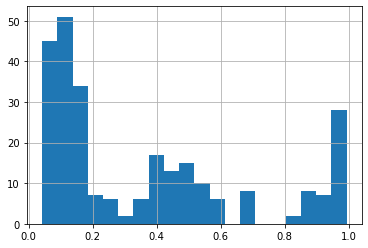

In [68]:
pd.Series(model_rf.predict_proba(X_test)[:, 1]).hist(bins=20)

In [69]:
model_hard_RF = pd.concat([df_test, pd.Series(model_rf.predict(test_[X_train.columns]), name='Survived')], axis=1); model_hard_RF

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


In [70]:
# сохраняем предикты

model_hard_RF[['PassengerId', 'Survived']].to_csv('hard_model_RF.csv', index=False)

##### Catboost

In [71]:
def objective(search_space):
    
    model = CatBoostClassifier(**search_space)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    
    return {'loss': -model.get_best_score()['validation']['AUC'], 'status': hyperopt.STATUS_OK}
    
search_space = {
    'learning_rate': hyperopt.hp.uniform('learning_rate', 0.01, 0.2), 
    'n_estimators': 10_000, 
    'od_type': 'Iter', 
    'od_wait': 1, 
    'l2_leaf_reg': hyperopt.hp.randint('l2_leaf_reg', 1000, 2000), 
    'depth': hyperopt.hp.randint('depth', 4, 6), 
    'bagging_temperature': hyperopt.hp.uniform('bagging_temperature', 0.01, 0.999), 
    'bootstrap_type': hyperopt.hp.choice('bootstrap_type', ['Bayesian']), 
    'boosting_type': hyperopt.hp.choice('boosting_type', ['Ordered', 'Plain']),
    'loss_function': hyperopt.hp.choice('loss_function', ['Logloss']),
    'random_strength': hyperopt.hp.uniform('random_strength', 0.001, 0.999), 
    'custom_loss': 'AUC'
               }

algoritm = hyperopt.tpe.suggest

best_params = hyperopt.fmin(fn=objective, 
                            space=search_space, 
                            algo=algoritm, 
                            max_evals=20)

hyperparams = hyperopt.space_eval(search_space, best_params)

hyperparams

100%|██████████| 20/20 [00:06<00:00,  2.87trial/s, best loss: -0.8580357142857142]


{'bagging_temperature': 0.02751338952227627,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'custom_loss': 'AUC',
 'depth': 4,
 'l2_leaf_reg': 1883,
 'learning_rate': 0.1641472883476067,
 'loss_function': 'Logloss',
 'n_estimators': 10000,
 'od_type': 'Iter',
 'od_wait': 1,
 'random_strength': 0.3039908879537043}

In [72]:
# best loss: -0.875937593759376       Попробуй его !

# hyperparams = {
# 'bagging_temperature': 0.03312039709269995,
#  'boosting_type': 'Plain',
#  'bootstrap_type': 'Bayesian',
#  'custom_loss': 'AUC',
#  'depth': 4,
#  'l2_leaf_reg': 1691,
#  'learning_rate': 0.12052212336003013,
#  'loss_function': 'Logloss',
#  'n_estimators': 10000,
#  'od_type': 'Iter',
#  'od_wait': 1,
#  'random_strength': 0.259868852933473
# }

In [73]:
hyperparams.pop('od_type', None)
hyperparams.pop('od_wait', None)
hyperparams['n_estimators'] = 200   # вручную смотрим

model = CatBoostClassifier(**hyperparams, verbose = 50)

model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=False)

roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
roc_auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

gini_train = roc_auc_train * 2 - 1
gini_test = roc_auc_test * 2 - 1

print(f'roc_auc_train - {roc_auc_train}')
print(f'gini_train - {gini_train}')
print('-'*50)
print(f'roc_auc_test - {roc_auc_test}')
print(f'gini_test - {gini_test}')
print('-'*50)
print(f'Overfitting - {gini_train - gini_test}')

0:	learn: 0.6821628	test: 0.6836919	best: 0.6836919 (0)	total: 742us	remaining: 148ms
50:	learn: 0.4632920	test: 0.5064932	best: 0.5064932 (50)	total: 32.3ms	remaining: 94.4ms
100:	learn: 0.4150161	test: 0.4715005	best: 0.4715005 (100)	total: 65.9ms	remaining: 64.6ms
150:	learn: 0.3963981	test: 0.4609837	best: 0.4609837 (150)	total: 99.8ms	remaining: 32.4ms
199:	learn: 0.3902486	test: 0.4583887	best: 0.4583882 (198)	total: 132ms	remaining: 0us

bestTest = 0.4583882047
bestIteration = 198

Shrink model to first 199 iterations.
roc_auc_train - 0.8953345542254778
gini_train - 0.7906691084509556
--------------------------------------------------
roc_auc_test - 0.8531547619047619
gini_test - 0.7063095238095238
--------------------------------------------------
Overfitting - 0.08435958464143178


In [74]:
model_hard_cb = pd.concat([df_test, pd.Series(model.predict(test_), name='Survived')], axis=1); model_hard_cb

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


In [75]:
# сохраняем предикты

model_hard_cb[['PassengerId', 'Survived']].to_csv('hard_model_cb.csv', index=False)

### KNN

In [76]:
from sklearn.neighbors import NearestNeighbors

knn = KNeighborsClassifier(n_jobs=-1)

params = {'n_neighbors': range(2, 15), 'weights': ['uniform', 'distance'], 'p': [1, 2]}

skf = StratifiedKFold(n_splits = 6, shuffle=True, random_state=9)

In [77]:
grid = GridSearchCV(knn, params, cv=skf, scoring='roc_auc')
grid.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=9, shuffle=True),
             estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid={'n_neighbors': range(2, 15), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [78]:
knn = grid.best_estimator_

In [79]:
print(f'Лучшие параметры - {grid.best_params_}')
print(f'Score на трейне - {knn.score(X_train, y_train)}')
print(f'Кросс score - {cross_val_score(knn, X_train,  y_train.values.ravel()).mean()}')

Лучшие параметры - {'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}
Score на трейне - 0.8640776699029126
Кросс score - 0.8057959611854184


In [80]:
y_predict = knn.predict(X_test)

In [81]:
y_predict_score = knn.predict_proba(X_test)

<AxesSubplot:>

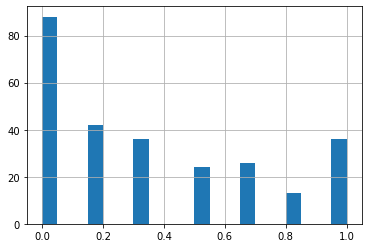

In [82]:
pd.Series(y_predict_score[:, 1]).hist(bins=20)

In [83]:
model_hard_knn = pd.concat([df_test, pd.Series(knn.predict(test_[X_train.columns]), name='Survived')], axis=1); model_hard_knn

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


In [84]:
# сохраняем предикты

model_hard_knn[['PassengerId', 'Survived']].to_csv('hard_model_knn.csv', index=False)

### SVC

In [85]:
# метод опорных векторов

parameters = {'kernel':('linear', 'rbf'), 
              'C':[1, 10], 
              'probability': [True]}
svc = SVC()
clf = GridSearchCV(svc, parameters, cv=4)
model_svc = clf.fit(X_train, y_train)

roc_auc_train = roc_auc_score(y_train, model_svc.predict_proba(X_train)[:, 1])
roc_auc_test = roc_auc_score(y_test, model_svc.predict_proba(X_test)[:, 1])

gini_train = roc_auc_train * 2 - 1
gini_test = roc_auc_test * 2 - 1

print(f'roc_auc_train - {roc_auc_train}')
print(f'gini_train - {gini_train}')
print('-'*50)
print(f'roc_auc_test - {roc_auc_test}')
print(f'gini_test - {gini_test}')
print('-'*50)
print(f'Overfitting - {gini_train - gini_test}')

roc_auc_train - 0.9031568250848669
gini_train - 0.8063136501697339
--------------------------------------------------
roc_auc_test - 0.8336309523809524
gini_test - 0.6672619047619048
--------------------------------------------------
Overfitting - 0.13905174540782905


In [86]:
model_svc.predict(test_[X_train.columns])

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [87]:
model_svc = pd.concat([df_test, pd.Series(model_svc.predict(test_[X_train.columns]), name='Survived')], axis=1); model_svc

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


In [88]:
# сохраняем предикт

model_svc[['PassengerId', 'Survived']].to_csv('hard_model_svc.csv', index=False)